In [1]:
import os
import cv2  # computer vision
import math
import time
import random
import numpy as np
import datetime as dt
import tensorflow as tf 
from tensorflow import keras
from collections import deque # deque is a double-ended queue that allows you to efficiently add and remove elements from both ends.
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import * # contains various layers used to built neural networks, dense layers, cnn layers etc...
from tensorflow.keras.models import Sequential # built linear stack layer
# Each layer in the stack processes the output of the previous layer, and this continues until the final layer produces the desired output
# data flows sequentially through each layer from the input to the output.
from tensorflow.keras.utils import to_categorical # one-hot-encodeing
# one of them is "hot" (set to 1) while the others are "cold" (set to 0). The position of the "hot" element indicates the class
from tensorflow.keras.callbacks import EarlyStopping 
# EarlyStopping is a callback in TensorFlow and Keras that is used during the training of a neural network to stop training early under certain conditions. 
# It helps prevent overfitting and can save training time
# Callbacks in Keras allow you to specify actions to be taken at different stages during training,
# such as early stopping
# from tensorflow.keras.utils import plot_model # visualize architecture of keras model.

In [2]:
# set Numpy, Python & Tensorflow seeds to get consistent results.
# same random values will be selected
seed_constant = 23
np.random.seed(seed_constant) # numpy random number
random.seed(seed_constant) # python random number
tf.random.set_seed(seed_constant) # tensorflow random number
SEQUENCE_LENGTH = 20
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64


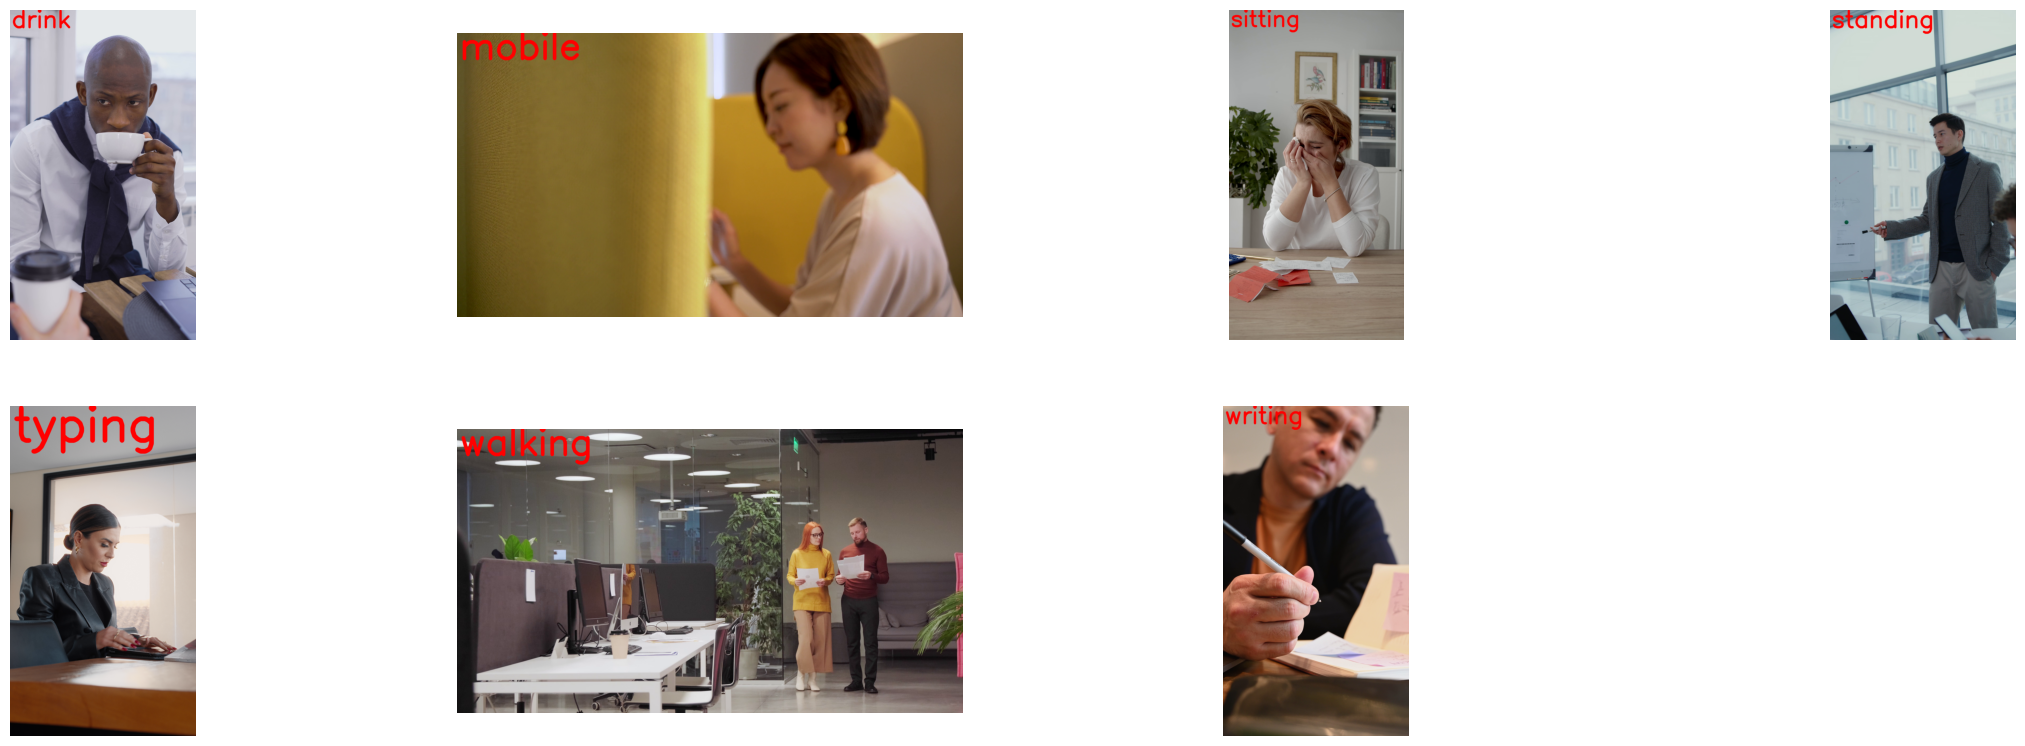

In [3]:
# Create a Matplotlib figure
plt.figure(figsize=(30, 30))

action_path = r"D:\ANACONDA3\envs\HARenv\HAR_Dataset"
# Get Names of all classes in UCF50
all_classes_names = os.listdir(action_path)

# Iterate through all the classes
for counter, class_name in enumerate(all_classes_names):
    # Get a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'D:\ANACONDA3\envs\HARenv\HAR_Dataset/{class_name}')

    # Check if there are any video files in this class directory
    if len(video_files_names_list) > 0:
        # Take the first video file from the list
        selected_video_file_name = video_files_names_list[0]

        # Reading the Video File Using the Video Capture
        video_reader = cv2.VideoCapture(f'D:\ANACONDA3\envs\HARenv\HAR_Dataset/{class_name}/{selected_video_file_name}')

        # Reading The First Frame of the Video File
        _, bgr_frame = video_reader.read()

        # Closing the VideoCapture object and releasing all resources.
        video_reader.release()

        # Converting the BGR Frame to RGB Frame
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Adding The Class Name Text on top of the Video Frame with increased size and thickness
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(rgb_frame, class_name, (20, 200), font, 9, (255, 0, 0), 25, cv2.LINE_AA)
        
        # Assigning the Frame to a specific position of a subplot
        plt.subplot(6, 4, counter + 1)  # Adjust the subplot grid as needed.
        plt.imshow(rgb_frame)
        plt.axis('off') # Turn off x and y axis.

# Show the Matplotlib figure
plt.show()


In [24]:
# read and process dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
DATASET_DIR = r"D:\ANACONDA3\envs\HARenv\HAR_Dataset"
CLASSES_LIST = list(all_classes_names)
SEQUENCE_LENGTH=20
model_output_size = len(CLASSES_LIST)
print(CLASSES_LIST)

['drink', 'mobile', 'sitting', 'standing', 'typing', 'walking', 'writing']


In [25]:
def frames_extraction(video_path):
    
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [26]:
def create_dataset():
   
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
# import tensorflow as tf

# # Set GPU memory growth (optional)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

In [8]:
# gpus

In [9]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: drink
Extracting Data of Class: mobile
Extracting Data of Class: sitting
Extracting Data of Class: standing
Extracting Data of Class: typing
Extracting Data of Class: walking
Extracting Data of Class: writing


In [11]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [12]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [13]:
# train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)
# X_train       X_test          Y_train       Y_test
# random_state - gives same results everytime, shuffle - True means data should be randomly shuffled before splitting or processing


In [27]:
def create_convlstm_model():
    tf.compat.v1.disable_eager_execution()

   
    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [28]:
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 20, 62, 62, 4)    1024      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 20, 31, 31, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, 20, 29, 29, 8)    3488      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 20, 15, 15, 8)    0         
 g3D)                                                            
                                                      

In [29]:
import tensorflow as tf

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Create an instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Define and compile the model
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model with non-eager execution
convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])


Train on 66 samples, validate on 17 samples
Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.9515 - accuracy: 0.1212

D:\ANACONDA3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


66/66 [==============================] - 55s 837ms/sample - loss: 1.9515 - accuracy: 0.1212 - val_loss: 1.9445 - val_accuracy: 0.1765
Epoch 2/50
66/66 [==============================] - 27s 407ms/sample - loss: 1.9420 - accuracy: 0.2576 - val_loss: 1.9430 - val_accuracy: 0.1176
Epoch 3/50
66/66 [==============================] - 27s 406ms/sample - loss: 1.9348 - accuracy: 0.2424 - val_loss: 1.9181 - val_accuracy: 0.2941
Epoch 4/50
66/66 [==============================] - 24s 364ms/sample - loss: 1.8943 - accuracy: 0.3485 - val_loss: 1.9468 - val_accuracy: 0.1765
Epoch 5/50
66/66 [==============================] - 31s 475ms/sample - loss: 1.7439 - accuracy: 0.3939 - val_loss: 2.0172 - val_accuracy: 0.1176
Epoch 6/50
66/66 [==============================] - 32s 488ms/sample - loss: 1.4546 - accuracy: 0.5000 - val_loss: 2.1291 - val_accuracy: 0.2353
Epoch 7/50
66/66 [==============================] - 32s 489ms/sample - loss: 1.2639 - accuracy: 0.5303 - val_loss: 2.8343 - val_accuracy: 0.1

In [30]:
# model evaluation
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [31]:
convlstm_model.save("HAR_ConvLSTM.h5")

In [32]:
from tensorflow import keras


In [33]:
model = keras.models.load_model('HAR_ConvLSTM.h5')

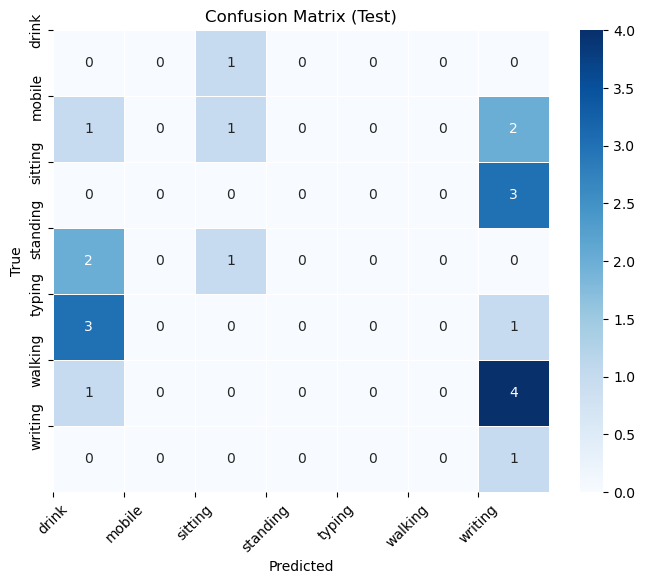

In [36]:
class_names = ['drink', 'mobile', 'sitting', 'standing', 'typing', 'walking', 'writing']


y_test_pred = convlstm_model.predict(features_test)

# Convert the predictions to class labels
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Get the true class labels for the test data
y_test_true = np.argmax(labels_test, axis=1)


# Compute the confusion matrix
confusion_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Create a confusion matrix graph for the test data with class names on axes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=.5)

# Set class names as labels on the x and y axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()